In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from sklearn.model_selection import train_test_split

import os
os.environ['OMP_NUM_THREADS'] = "1"

In [2]:
obdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'

### Choose which sites to train the SVR model on
Can be all available, or a defined list 'site_list' passed, or single station as list e.g. ['CLN']<br>
Use all with an exclude list is another alternative

In [106]:
flist = glob(obdir + 'combined/*.pd')

# This can be a manual site list if desired
site_list = np.unique([f.split('/')[-1].split('_')[0] for f in flist])
site_list = ['CLN']

site_list

['CLN']

### For each site, choose which files to use
For now, we will only use one set of observations from each site so samples remain independent<br>
We can change this behavior down the road to use all or some intervals<br>
Favor 'short' for the shortest interval available e.g. 6h, 'long' for longest interval e.g. 24h

In [107]:
favor = 'short' #'long'

flist = []
for site in site_list:
    
    site_files = glob(obdir + 'combined/%s*.pd'%site)
    
    if len(site_files) > 1:
        if favor == 'short':
            flist.append(
                site_files[np.argmin([int(f.split('.')[-2].replace('h', '')) 
                    for f in site_files])])
            
        elif favor == 'long':
            np.argmax([int(f.split('.')[-2].replace('h', '')) for f in site_files])
    
    else:
        flist.append(site_files[0])
        
flist

['/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/CLN_1999_2019.12h.pd']

### Establish which model variables and levels to use
This is entirely based on the model that the SVR will be applied to - maximize the predictor set<br>
Helpful to open a sample GFS/NAM/HRRR grid or profile to derive the variable list from

In [108]:
# For now we can reuse the fixed list from the proof-of-concept script
# But this needs to be made flexible
gfs_keys = [
       'VO1000', 'VO400', 'VO450', 'VO500', 'VO550', 'VO600', 'VO650',
       'VO700', 'VO750', 'VO800', 'VO850', 'VO900', 'VO925', 'VO950',
       'VO975', 'CAPE', 'DIR1000', 'DIR400', 'DIR450', 'DIR500', 'DIR550',
       'DIR600', 'DIR650', 'DIR700', 'DIR750', 'DIR800', 'DIR850',
       'DIR900', 'DIR925', 'DIR950', 'DIR975', 'Z1000', 'Z400', 'Z450',
       'Z500', 'Z550', 'Z600', 'Z650', 'Z700', 'Z750', 'Z800', 'Z850',
       'Z900', 'Z925', 'Z950', 'Z975', 'RH1000', 'RH400', 'RH450',
       'RH500', 'RH550', 'RH600', 'RH650', 'RH700', 'RH750', 'RH800',
       'RH850', 'RH900', 'RH925', 'RH950', 'RH975', 'SP', 'SPD1000',
       'SPD400', 'SPD450', 'SPD500', 'SPD550', 'SPD600', 'SPD650',
       'SPD700', 'SPD750', 'SPD800', 'SPD850', 'SPD900', 'SPD925',
       'SPD950', 'SPD975', 'T1000', '2T', 'T400', 'T450', 'T500', 'T550',
       'T600', 'T650', 'T700', 'T750', 'T800', 'T850', 'T900', 'T925',
       'T950', 'T975', 'TSFC', 'U1000', 'U400', 'U450', 'U500', 'U550',
       'U600', 'U650', 'U700', 'U750', 'U800', 'U850', 'U900', 'U925',
       'U950', 'U975', 'V1000', 'V400', 'V450', 'V500', 'V550', 'V600',
       'V650', 'V700', 'V750', 'V800', 'V850', 'V900', 'V925', 'V950',
       'V975', 'W1000', 'W400', 'W450', 'W500', 'W550', 'W600', 'W650',
       'W700', 'W750', 'W800', 'W850', 'W900', 'W925', 'W950', 'W975']

gfs_levels = [400, 450, 500,550,600, 650, 700, 750, 
              800, 850, 900, 925, 950, 975, 1000]

exclude_keys = []#['Z', '2T', 'TSFC', 'SP', 'CAPE', 'VO', 'W']

exclude_keys = np.array([[k if ex in k[:len(ex)] else np.nan 
                          for ex in exclude_keys] for k in gfs_keys])
exclude_keys = exclude_keys.flatten()
exclude_keys = exclude_keys[exclude_keys != 'nan']

gfs_keys = np.array([k for k in gfs_keys if k not in exclude_keys])
gfs_keys

/uufs/chpc.utah.edu/common/home/u1070830/.conda/envs/downscaled_slr/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/uufs/chpc.utah.edu/common/home/u1070830/.conda/envs/downscaled_slr/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


array(['VO1000', 'VO400', 'VO450', 'VO500', 'VO550', 'VO600', 'VO650',
       'VO700', 'VO750', 'VO800', 'VO850', 'VO900', 'VO925', 'VO950',
       'VO975', 'CAPE', 'DIR1000', 'DIR400', 'DIR450', 'DIR500', 'DIR550',
       'DIR600', 'DIR650', 'DIR700', 'DIR750', 'DIR800', 'DIR850',
       'DIR900', 'DIR925', 'DIR950', 'DIR975', 'Z1000', 'Z400', 'Z450',
       'Z500', 'Z550', 'Z600', 'Z650', 'Z700', 'Z750', 'Z800', 'Z850',
       'Z900', 'Z925', 'Z950', 'Z975', 'RH1000', 'RH400', 'RH450',
       'RH500', 'RH550', 'RH600', 'RH650', 'RH700', 'RH750', 'RH800',
       'RH850', 'RH900', 'RH925', 'RH950', 'RH975', 'SP', 'SPD1000',
       'SPD400', 'SPD450', 'SPD500', 'SPD550', 'SPD600', 'SPD650',
       'SPD700', 'SPD750', 'SPD800', 'SPD850', 'SPD900', 'SPD925',
       'SPD950', 'SPD975', 'T1000', '2T', 'T400', 'T450', 'T500', 'T550',
       'T600', 'T650', 'T700', 'T750', 'T800', 'T850', 'T900', 'T925',
       'T950', 'T975', 'TSFC', 'U1000', 'U400', 'U450', 'U500', 'U550',
       'U600', 'U

### Import the compiled data
Prune unused variables on import based on the list above<br>
Sub-surface levels have already been dealt with in the compilation script - modify methods there<br>
Note that 12 vs 24 hour intervals have also been dealt with above, if both desired... write that in

In [109]:
use_var_type = ['mean']#, 'max', 'min']

data = []
for f in flist:
    
    site = f.split('/')[-1].split('_')[0]
    interval = int(f.split('/')[-1].split('.')[-2].replace('h', ''))
    
    df = pd.read_pickle(f)

    keys = ['slr%d'%interval, 'swe%d_mm'%interval]
    
    keys.extend(np.hstack([[k for k in df.keys() 
                  if ((vt in k) & (k.split('_')[0] in gfs_keys))] 
                 for vt in use_var_type]))

    df = df.loc[:, keys].rename(columns={[k for k in keys if 'swe' in k][0]:'swe_mm'})
    df = df.rename(columns={[k for k in keys if 'slr' in k][0]:'slr'})
    
    # df.insert(0, 'site', np.full(df.index.size, fill_value=site, dtype='U10'))
    doy = [int(pd.to_datetime(d).strftime('%j')) for d in df.index]
    df.insert(2, 'day_of_year', doy)
    
    data.append(df.reset_index().drop(columns='time'))

data = pd.concat(data, sort=False)

# Treat the mean value as the instantaneous value for later applications,
# we can change this behavior later on if desired. 
# An alternate method would be to keep the 'mean' tag through training 
# and choose behavior upon application
data = data.rename(columns={k:k.replace('_mean', '') for k in data.keys()})

print(data.shape)
data.head()

(1665, 68)


,slr,swe_mm,day_of_year,T400,U400,V400,VO400,W400,Z400,SPD400,...,SPD750,T800,U800,V800,VO800,W800,Z800,SPD800,CAPE,SP
0,9.523809,10.668,312,245.751221,14.262792,18.845314,-0.000007,-0.282659,72119.179688,23.807833,...,11.576412,286.184265,-0.407485,5.358132,-0.000366,0.256965,19498.025391,5.541474,1.038462,80253.921875
1,11.320755,13.462,321,245.860687,13.253074,27.635181,-0.000044,-0.518515,71582.046875,30.789095,...,11.845341,286.156799,-0.658640,4.628677,-0.000338,0.191280,18832.937500,5.377541,0.153846,79608.828125
2,8.695652,5.842,324,247.194550,23.618073,13.456594,-0.000019,0.183329,72402.429688,27.394947,...,10.392151,281.588654,-1.551895,3.541852,-0.000251,0.402385,19654.679688,3.930658,0.548077,80416.054688
3,18.181818,2.794,324,243.966476,26.156818,9.112763,0.000035,-0.103810,71192.046875,28.957607,...,5.438491,277.557007,0.522875,1.790523,-0.000107,0.006187,19554.835938,2.677736,2.927885,80313.203125
4,16.071428,7.112,325,242.414658,25.918653,-0.349203,0.000037,-0.012761,70443.890625,26.516172,...,2.433492,275.800568,-0.293900,-0.477268,0.000029,0.294072,19316.310547,1.532066,4.125000,80073.867188


### Hard trim data based on criteria

In [110]:
min_slr, max_slr = 2.5, 30
max_T650 = 0 + 273.15
min_swe_mm = 2.54

data = data[data['slr'] >= min_slr]
data = data[data['slr'] <= max_slr]
data = data[data['T650'] <= max_T650]
data = data[data['swe_mm'] >= min_swe_mm]

data = data[[k for k in data.keys() if 'swe' not in k]]

print(data.shape)

(1519, 67)


<hr><hr>

### Investigate basic bulk statistics and linear correlations
Quanitfy how certain variables are related and produce plots to visualize this<br>

#### *Removed: Normalize/Standardize
Moved down to where datasets are split. If need be we can normalize for the plots below here too...

#### Pair Plots

#### Correlation Matrix, R2 Matrix

#### Linear Correlation Verical Plots, R2 Vertical Plots

#### Identify autocorrelated and other dependent predictors
Mask these if desired

<hr><hr>

### Split Train/Test/Validate Sets
If we want to expand the hyperparameter tuning, we can test for sensitivity to random sample<br>
by looping from bottom of code block back to here<br>

In [111]:
# int(slr) for stratification (> 1 ct per class label)
data = data.dropna()
fac = 2
slr = np.round(data['slr']/fac, 0)*fac
slr.value_counts()

# data['slr'] = slr

10.0    238
12.0    222
16.0    196
8.0     191
14.0    156
18.0    121
6.0     113
20.0    102
24.0     56
22.0     55
4.0      28
26.0     15
28.0     13
30.0     11
2.0       2
Name: slr, dtype: int64

In [112]:
# Split into train/test sets
train_size, test_size, random_state = None, 0.33, 10
X_train, X_test = train_test_split(data, 
                                       test_size=test_size, train_size=train_size, 
                                       random_state=random_state, stratify=slr)

# Perform a secondary split if separate validation set required

# Split off the target variable now that TTsplit is done
y_train, y_test = X_train.pop('slr'), X_test.pop('slr')
# y_train = np.round(y_train/fac, 0)*fac

print('Train: {}\nTest: {}\nValidate: {}'.format(X_train.shape[0], X_test.shape[0], None))

train_stats = X_train.describe().T
train_stats.head(10)

Train: 1017
Test: 502
Validate: None


,count,mean,std,min,25%,50%,75%,max
day_of_year,1017.0,155.295969,135.176284,1.000000,47.000000,8.800000e+01,324.000000,366.000000
T400,1017.0,239.866104,4.509378,224.297226,236.958267,2.402485e+02,243.160507,251.491348
U400,1017.0,19.156443,11.569384,-16.917448,11.061075,1.922440e+01,26.402649,59.784084
V400,1017.0,3.720218,15.275477,-54.728245,-5.490825,5.094398e+00,14.151258,45.693340
VO400,1017.0,0.000010,0.000051,-0.000108,-0.000025,-4.507422e-07,0.000035,0.000263
W400,1017.0,-0.085564,0.291611,-1.317631,-0.225382,-4.292385e-02,0.096256,0.873093
Z400,1017.0,70259.148438,1090.618164,66812.320312,69528.617188,7.028318e+04,71089.125000,72975.968750
SPD400,1017.0,25.738329,10.453670,3.018148,18.272676,2.570155e+01,32.985020,67.926323
T450,1017.0,245.940735,4.539683,230.203537,243.061523,2.464266e+02,249.321548,256.540161
U450,1017.0,16.817188,9.805645,-11.972133,10.219059,1.683064e+01,22.956785,52.233501


### Normalize/Standardize the data
We are using z-score normalization for now but other methods exist<br>
This is an absolute must for working with any of the ML models available to us<br>
Normalize based on the TRAINING dataset

In [113]:
# def zscore(x, mu, sigma):
#     '''Standardization'''
#     return (x - mu) / sigma

In [114]:
# X_train_norm = zscore(X_train, train_stats['mean'], train_stats['std'])
# X_test_norm = zscore(X_test, train_stats['mean'], train_stats['std'])

# X_train_norm.describe().T.head(10)

Print out plots describing the variability in the data (+ before/after normalization?)<br>
It would be valuable to do a similar set of/novel comparison plots with the ERA5 vs GFS<br>
for each variable/level in the validation script (separate from and following this script)

In [115]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor as MLP

mae = make_scorer(mean_absolute_error, greater_is_better=False)

steps = [('scaler', RobustScaler(quantile_range=(25, 75))), ('MLP', MLP())] #('SVR', SVR(kernel='rbf'))]
pipeline = Pipeline(steps) # define the pipeline object.

In [124]:
import multiprocessing as mp

parameteres = {'MLP__alpha':[1.0, 5, 10, 30, 50, 100]} #{'SVR__C':np.arange(1, 10, 1), 'SVR__epsilon':np.arange(0, 5.1, 0.5), 'SVR__gamma':np.arange(0.01, 0.1, 0.02)}
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5, n_jobs=int(mp.cpu_count()*0.75), scoring=None, verbose=True)
grid

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25, 75), with_centering=True,
       with_scaling=True)), ('MLP', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learnin...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=60,
       param_grid={'MLP__alpha': [1.0, 5, 10, 30, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [125]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=60)]: Done   4 out of  30 | elapsed:   15.2s remaining:  1.6min
[Parallel(n_jobs=60)]: Done  30 out of  30 | elapsed:   21.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25, 75), with_centering=True,
       with_scaling=True)), ('MLP', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learnin...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=60,
       param_grid={'MLP__alpha': [1.0, 5, 10, 30, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [126]:
abs(grid.score(X_test, y_test)), grid.best_params_

(0.30326197884324113, {'MLP__alpha': 100})

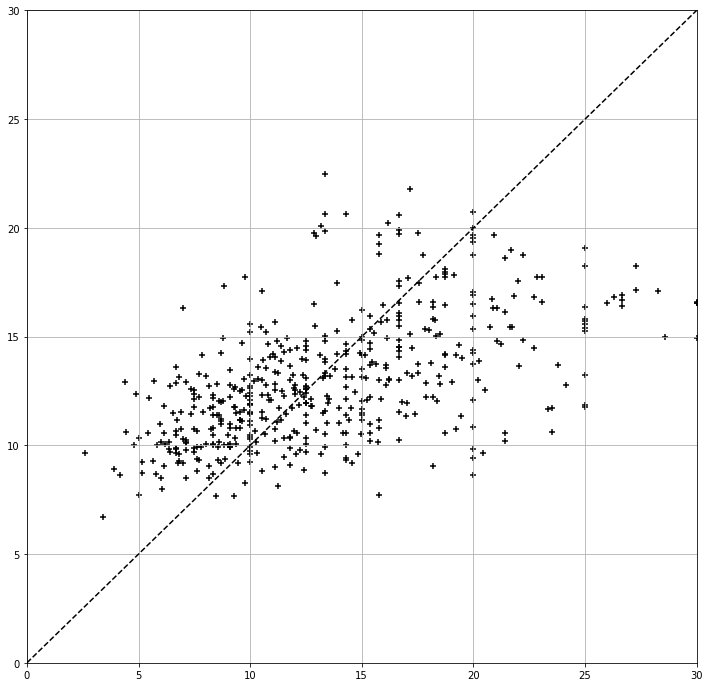

In [127]:
plt.figure(facecolor='w', figsize=(12, 12))
plt.plot(range(31), range(31), 'k--')
plt.scatter(y_test, grid.predict(X_test), color='k', marker='+')
plt.xlim([0, 30])
plt.ylim([0, 30])
plt.grid()